# Classifying Malicious Software using Random Forest

The emergence of graph data across many scientific fields has led to intense interest in the development of representation learning techniques that encode structured information into low dimensional space for a variety of important downstream tasks (e.g., toxic molecule detection, community clustering, malware detection).

In this lab, we walk through how to use **random forests** to classify different *types* of malicious software using function call graphs (FCGs) extracted from malicious files. Each FCG represents the calling relationships between functions in a program, where nodes are functions and edges indicate inter-procedural calls. We obtain these FCGs from [**MalNet**](https://mal-net.org/), a large-scale graph classification database.Specifically, we will look at how to:

- Part 1: Download and process the data,
- Part 2: Get train and test data
- Part 3: Random Forest Classifier Hyperparameter tuning
- Part 4: Measuring Accuracy


## Part 1. Downloading and processing the data

We first download the graph data from the MalNet website, [here](http://malnet.cc.gatech.edu/graph-data/malnet-graphs-tiny.tar.gz) and [here](http://malnet.cc.gatech.edu/split-info/split_info_tiny.zip), and store it locally in the folder `notebooks/`.

In [1]:
!mkdir notebooks

In [2]:
import shutil
import requests

def download_data(url, target_path):
    """
    Download MalNet-Tiny data to the local device
    :param: url: a string representing the url download location
    :param: target_path: a string representing the local storage location
    """

    response = requests.get(url, stream=True)

    # check that the data was successfully retrieved
    if response.status_code == 200:
        with open(target_path, 'wb') as f:
            f.write(response.raw.read())

    # uncompress the downloads
    shutil.unpack_archive(target_path, 'notebooks/')

download_data(url='http://malnet.cc.gatech.edu/graph-data/malnet-graphs-tiny.tar.gz', target_path='notebooks/malnet-graphs-tiny.tar.gz')
download_data(url='http://malnet.cc.gatech.edu/split-info/split_info_tiny.zip', target_path='notebooks/split_info_tiny.zip')

Now that the data has been downloaded, lets gather the file paths and label information for the train, validation and test sets.

In [3]:
def get_split_info(data_type, data_dir='notebooks/malnet-graphs-tiny/'):
    """
    Get the file paths and labels for the train, val or test data
    :param: data_type: a string representing the data selection 'train', 'val' or 'test'
    :param: the graph directory
    :return: list of graph filepaths, list of labels, and label dictionary 
    """

    # read the train/val/test file split info into memory
    with open('notebooks/split_info_tiny/type/{}.txt'.format(data_type), 'r') as f:
        lines = f.readlines()

    # parse graph file paths
    files = [data_dir + l.strip() + '.edgelist' for l in lines]
    print('Number of {} samples: {}'.format(data_type, len(files)))

    # get the class labels for each graph
    graph_classes = sorted(list(set([file.split(data_dir)[1].split('/')[0] for file in files])))
    label_dict = {t: idx for idx, t in enumerate(graph_classes)}
    labels = [label_dict[file.split(data_dir)[1].split('/')[0]] for file in files]

    return files, labels, label_dict

__<span style="color:red">Exercise1a:</span>__: Call get_split_info function with parameter data_type='train'. Save output into 3 variables: files_train, train_labels, label_dict

In [4]:
files_train, train_labels, label_dict = get_split_info(data_type='train')

Number of train samples: 3500


__<span style="color:red">Exercise1b:</span>__: Call get_split_info function with parameter data_type='val'. Save output into 2 variables: files_val, val_labels

In [5]:
files_val, val_labels, _ = get_split_info(data_type='val')

Number of val samples: 500


__<span style="color:red">Exercise1c:</span>__: Call get_split_info function with parameter data_type='test'. Save output into 2 variables: files_test, test_labels

In [6]:
files_test, test_labels, _ = get_split_info(data_type='test')

Number of test samples: 1000


To get a feeling for the data we are going to be working with, lets visualize one of the graphs.

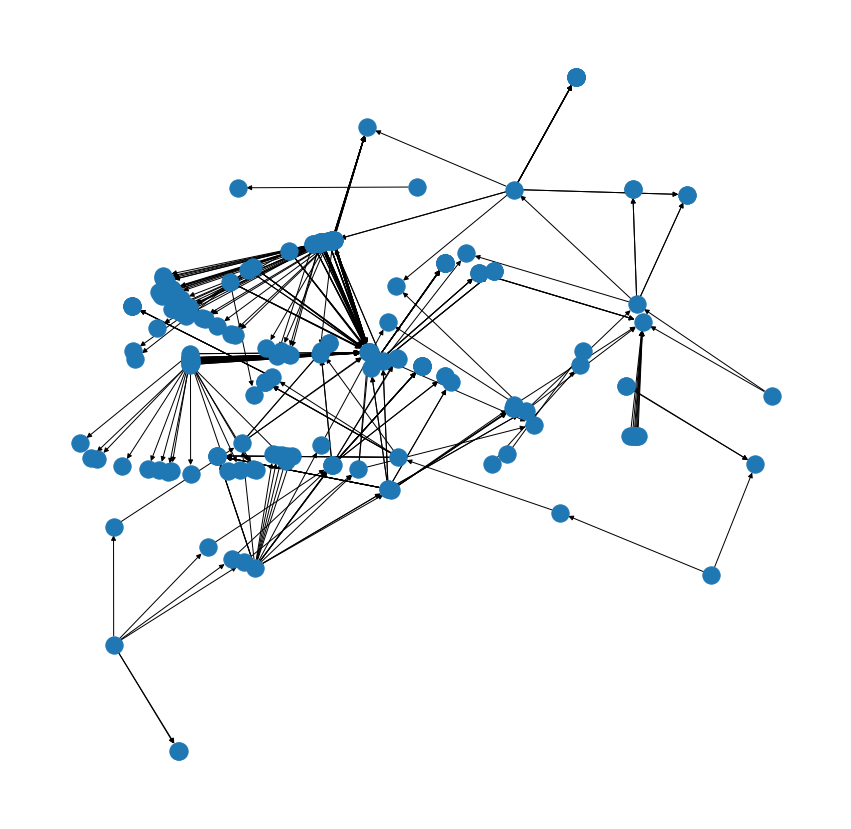

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# load a single function call graph
graph = nx.read_edgelist(files_train[2], create_using=nx.DiGraph)

# plot the graph using the Kamada Kawai graph layout
plt.figure(num=None, figsize=(15, 15))
plt.axis('off')
nx.draw_kamada_kawai(graph)

In the figure above, we can see that the graph is directed which represents the interprocedural function calls i.e., each node is a function and an edge represents that function calling another function.

## Part 2. Get train and test data

Let's now break our data into a training set, a validation set, and a testing set. We will train our random forest models with our training data and then tune the model's hyperparameters using the validation data. We will finally evaluate the best random forest model using our testing data.

In [8]:
import numpy as np
import networkx as nx
train_arr, val_arr, test_arr = [], [], []

In [9]:
for file in files_train:
  graph = nx.read_edgelist(file)
  train_arr.append([len(graph.nodes), len(graph.edges)])

In [10]:
for file in files_val:
  graph = nx.read_edgelist(file)
  val_arr.append([len(graph.nodes), len(graph.edges)])

In [11]:
for file in files_test:
  graph = nx.read_edgelist(file)
  test_arr.append([len(graph.nodes), len(graph.edges)])

## Part 3. Random Forest Classifier (sklearn) Hyperparamter tuning

In [12]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

Here are all the different hyperparameter arguments we want to vary and the respective inputs that we want to test.

In [13]:
n_estimators_choice = [25, 50, 100, 200]
max_depth_choice = [4, 16, 32]

Test all the different combinations of hyperparameters and return the set of hyperparameters that fit the validation dataset the best. If there are multiple combinations that achieve the same accuracy, use the combination that leads to the simplest model.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
                 'n_estimators': [25, 50, 100, 200],
                 'max_depth': [4, 16, 32],
             }


rf_cv_model = GridSearchCV(rf_model, param_grid, cv=10).fit(val_arr, val_labels) 

In [15]:
%%time
rf_tuned = RandomForestClassifier(**rf_cv_model.best_params_).fit(train_arr, train_labels)

CPU times: user 327 ms, sys: 12 ms, total: 339 ms
Wall time: 338 ms


In [16]:
y_pred = rf_tuned.predict(test_arr)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       200
           1       0.67      0.80      0.73       200
           2       0.65      0.58      0.61       200
           3       0.98      0.99      0.99       200
           4       0.88      0.78      0.82       200

    accuracy                           0.78      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000



In [17]:
rf_cv_model.best_params_

{'max_depth': 16, 'n_estimators': 100}

## Part 4. Random Forest Classifier (cuML) dataset preparation

Now we will need to convert it into values that cuML's random forest classifier (RFC) takes. The documentation for cuML's RFC can be found [here](https://docs.rapids.ai/api/cuml/stable/api.html#cuml.ensemble.RandomForestClassifier).

__<span style="color:red">Exercise2a:</span>__: Create numpy array for the datasets and convert to 32-bit floating-point number(float32)

In [18]:
train_arr = np.array(train_arr).astype(np.float32)
val_arr = np.array(val_arr).astype(np.float32)
test_arr = np.array(test_arr).astype(np.float32)

__<span style="color:red">Exercise2b:</span>__: Create numpy array for the datasets labels and convert to 32-bit int number(int32)

In [19]:
train_labels = np.array(train_labels).astype(np.int32)
val_labels = np.array(val_labels).astype(np.int32)
test_labels = np.array(test_labels).astype(np.int32)

In [20]:
#Looking at the shape of all the arrays
print("train_arr: ", train_arr.shape)
print("val_arr: ", val_arr.shape)
print("test_arr: ", test_arr.shape)

train_arr:  (3500, 2)
val_arr:  (500, 2)
test_arr:  (1000, 2)


In [21]:
print("train_arr dict: ", label_dict)

train_arr dict:  {'addisplay': 0, 'adware': 1, 'benign': 2, 'downloader': 3, 'trojan': 4}


## Part 5. Random Forest Classifier (cuML) Hyperparamter tuning

In [22]:
from cuml.ensemble import RandomForestClassifier as cuRFC

__<span style="color:red">Exercise3a:</span>__: Rewrite the Random Forest Classifier (sklearn) Hyperparamter tuning code into cuML version.

In [23]:
from sklearn.model_selection import GridSearchCV
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
                 'n_estimators': [25, 50, 100, 200],
                 'max_depth': [4, 16, 32],
             }

rf_cv_model = GridSearchCV(rf_model, param_grid, cv=10).fit(val_arr, val_labels) 

__<span style="color:red">Exercise3b:</span>__: Calculate the time taken for cuRFC to train the model.

In [26]:
%%time
rf_tuned = cuRFC(**rf_cv_model.best_params_).fit(train_arr, train_labels)

CPU times: user 80 ms, sys: 31.8 ms, total: 112 ms
Wall time: 40.2 ms


__<span style="color:red">Exercise3c:</span>__: Show the best parameters for cuRFC trained model

In [25]:
rf_cv_model.best_params_

{'max_depth': 16, 'n_estimators': 100}